In [1]:
!mkdir ~/.kaggle
!mkdir .kaggle

In [2]:
import json
token = {"username":"ee17b046","key":"8ebf0dfa9a52e9c4bb4d6004aa33f6d9"}
with open('/content/.kaggle/kaggle.json', 'w') as file:
    json.dump(token, file)

In [3]:
!cp /content/.kaggle/kaggle.json ~/.kaggle/kaggle.json

In [4]:
!chmod 600 /root/.kaggle/kaggle.json

In [5]:
!kaggle datasets download -d ktaebum/anime-sketch-colorization-pair 

100% 11.6G/11.6G [04:40<00:00, 74.3MB/s]
100% 11.6G/11.6G [04:40<00:00, 44.6MB/s]


In [ ]:
!unzip /content/anime-sketch-colorization-pair.zip -d /content

In [7]:
!rm -rf /content/data/colorgram
!rm -rf /content/data/data

In [8]:
!rm /content/anime-sketch-colorization-pair.zip

In [9]:
params = {
    'batch_size':10,
    'input_size':128,
    'resize_scale':128,
    'crop_size':128,
    'fliplr':True,
    #model params
    'num_epochs':100,
    'decay_epoch':100,
    'ngf':32,   #number of generator filters
    'ndf':64,   #number of discriminator filters
    'num_resnet':6, #number of resnet blocks
    'lrG':0.0002,    #learning rate for generator
    'lrD':0.0002,    #learning rate for discriminator
    'beta1':0.5 ,    #beta1 for Adam optimizer
    'beta2':0.999 ,  #beta2 for Adam optimizer
    'lambdaA':10 ,   #lambdaA for cycle loss
    'lambdaB':10  ,  #lambdaB for cycle loss
}

In [10]:
from __future__ import print_function

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data

from PIL import Image
import matplotlib.pyplot as plt

import torchvision.transforms as transforms
import torchvision.models as models

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from torch.autograd import Variable
import torch.utils.data as data
import random

import os , itertools

import matplotlib.pyplot as plt


In [11]:
from google.colab import output

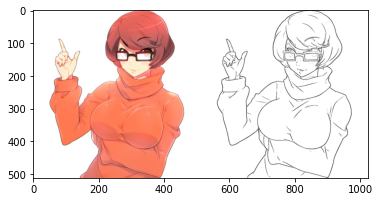

In [12]:
path1 = '/content/data/train/1000000.png'
img = Image.open(path1).convert('RGB')
plt.imshow(img)
w,h = img.size

(512, 512)
(512, 512)


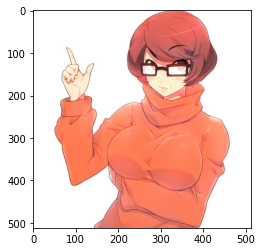

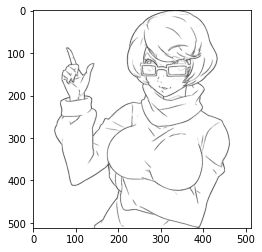

In [13]:
img1 = img.crop((0,0,w//2,h))
plt.imshow(img1)
print(img1.size)
img2 = img.crop((w//2,0,w,h))
plt.figure()
plt.imshow(img2)
print(img2.size)

In [14]:
class DatasetFromFolder(data.Dataset):
    def __init__(self, image_dir, subfoldertype='train', transform=None, resize_scale=None, crop_size=False, fliplr=False,number = None):
        super(DatasetFromFolder, self).__init__()
        self.input_path = os.path.join(image_dir, subfoldertype)
        self.image_filenames = [x for x in sorted(os.listdir(self.input_path))]#[:1000]
        self.transform = transform
        
        self.resize_scale = resize_scale
        self.crop_size = crop_size
        self.fliplr = fliplr
        self.a = Image.open(os.path.join(self.input_path, self.image_filenames[0])).convert('RGB')
        self.w,self.h = self.a.size

    def __getitem__(self, index):
        # Load Image
        img_fn = os.path.join(self.input_path, self.image_filenames[index])
        img = Image.open(img_fn).convert('RGB')
        img1 = img.crop((0,0,self.w//2,self.h))
        img2 = img.crop((self.w//2,0,self.w,self.h))


        # preprocessing
        if self.resize_scale:
            img1 = img1.resize((self.resize_scale, self.resize_scale), Image.BILINEAR)
            img2 = img2.resize((self.resize_scale, self.resize_scale), Image.BILINEAR)

        if self.fliplr:
            if random.random() < 0.5:
                img1 = img1.transpose(Image.FLIP_LEFT_RIGHT)
                img2 = img2.transpose(Image.FLIP_LEFT_RIGHT)

        if self.transform is not None:
            img1 = self.transform(img1)
            img2 = self.transform(img2)

        return img1,img2

    def __len__(self):
        return len(self.image_filenames)


In [15]:
#img = Image.open('/content/data/trainA/1000000.png').convert('RGB')
#img = img.resize((128,128), Image.BILINEAR)

In [16]:
transform = transforms.Compose([
    transforms.Resize(size=params['input_size']),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
])

In [17]:
data_dir = '/content/data/'
train_data_A = DatasetFromFolder(data_dir, subfoldertype='train', transform=transform,
                                resize_scale=params['resize_scale'])
total = train_data_A.__len__()
print(train_data_A.__len__())
train_data_loader_A = torch.utils.data.DataLoader(dataset=train_data_A, batch_size=params['batch_size'], shuffle=True)
#Load test data
test_data_A = DatasetFromFolder(data_dir, subfoldertype='val', transform=transform,resize_scale=params['resize_scale'])
test_data_loader_A = torch.utils.data.DataLoader(dataset=test_data_A, batch_size=1, shuffle=True)

14224


In [18]:
%matplotlib inline

In [19]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [20]:
device

device(type='cuda')

#create generator

In [21]:
!pip install pytorch-model-summary
from pytorch_model_summary import summary

In [22]:
class P2P_Generator(nn.Module):
  def __init__(self):
    super(P2P_Generator,self).__init__()
    self.c1 = nn.Conv2d(3,8,3,2,1,bias=False)
    self.b1 = nn.BatchNorm2d(8)
    self.a1 = nn.LeakyReLU(True)
    self.c2 = nn.Conv2d(8,16,3,2,1,bias=False)
    self.b2 = nn.BatchNorm2d(16)
    self.a2 = nn.LeakyReLU(True)
    self.c3 = nn.Conv2d(16,32,3,2,1,bias=False)
    self.b3 = nn.BatchNorm2d(32)
    self.a3 = nn.LeakyReLU(True)
    self.c4 = nn.Conv2d(32,64,3,2,1,bias= False)
    self.b4 = nn.BatchNorm2d(64)
    self.a4 = nn.LeakyReLU(True)

    self.ct4= nn.ConvTranspose2d(64,32,4,2,1,bias= False)
    self.bt4= nn.BatchNorm2d(32)
    self.at4 = nn.LeakyReLU(True)
    self.ct3= nn.ConvTranspose2d(64,16,4,2,1,bias= False)
    self.bt3= nn.BatchNorm2d(16)
    self.at3= nn.LeakyReLU(True)
    self.ct2= nn.ConvTranspose2d(32,8,4,2,1,bias=False)
    self.bt2= nn.BatchNorm2d(8)
    self.at2= nn.LeakyReLU(True)
    self.ct1= nn.ConvTranspose2d(16,3,4,2,1,bias = False)
    self.bt1= nn.BatchNorm2d(3)
    self.at1 = nn.LeakyReLU(True)

    self.dt3 = nn.Dropout2d(0.3)
    self.dt2 = nn.Dropout2d(0.3)
    self.dt1 = nn.Dropout2d(0.3)
  
  def forward(self,input):
    #shape 3 *128*128
    q = self.c1(input)   #
    #8*64*64             #
    q1 = self.b1(q)      #
    q1 = self.a1(q1)     #
    #8*64*64             #
    q2 = self.c2(q1)     #
    q2 = self.b2(q2)     #
    q2 = self.a2(q2)     #  
    #16*32*32            #
    q3 = self.c3(q2)     #
    q3 = self.b3(q3)     #
    q3 = self.a3(q3)     #====/
    #32*16*16            #
    q4 = self.c4(q3)     #   
    q4 = self.b4(q4)     #
    q4 = self.a4(q4)     #
    #16*8*8              #
    q5 = self.ct4(q4)    #
    q5 = self.bt4(q5)    #
    q5 = self.at4(q5)    #
    #32*16*16            #     1
    q6 = self.ct3(torch.cat((q3, q5), 1)) #=====\torch.cat((q3, q5), 1)
    q6 = self.bt3(q6)    #
    q6 = self.at3(q6)    #
    #16*32*32            #
    q7 = self.ct2(torch.cat((q2, q6), 1)) #torch.cat((q2, q6), 1)
    q7 = self.bt2(q7)    #
    q7 = self.at2(q7)#####   
    #8*64*64##############torch.cat((q1, q7), 1)
    q8 = self.ct1(torch.cat((q1, q7), 1))##
    q8 = self.bt1(q8)#####
    q8 = self.at1(q8)#####
    #3*128*128
    return q8
  

In [23]:
generator = P2P_Generator()
print(summary(generator.to(device), torch.zeros((1, 3, 128,128)).to(device), show_input=True))

---------------------------------------------------------------------------
         Layer (type)          Input Shape         Param #     Tr. Param #
             Conv2d-1     [1, 3, 128, 128]             216             216
        BatchNorm2d-2       [1, 8, 64, 64]              16              16
          LeakyReLU-3       [1, 8, 64, 64]               0               0
             Conv2d-4       [1, 8, 64, 64]           1,152           1,152
        BatchNorm2d-5      [1, 16, 32, 32]              32              32
          LeakyReLU-6      [1, 16, 32, 32]               0               0
             Conv2d-7      [1, 16, 32, 32]           4,608           4,608
        BatchNorm2d-8      [1, 32, 16, 16]              64              64
          LeakyReLU-9      [1, 32, 16, 16]               0               0
            Conv2d-10      [1, 32, 16, 16]          18,432          18,432
       BatchNorm2d-11        [1, 64, 8, 8]             128             128
         LeakyReLU-12   

#create discriminator

In [24]:
class Discriminator(nn.Module):
  def __init__(self):
    super(Discriminator,self).__init__()
    self.main = nn.Sequential(
            # input is 6 x 128 x 128
            nn.Conv2d(6, 8, 3, 2, 1, bias=False),
            nn.LeakyReLU(0.2),
            # state size. (8) x 64 x 64
            nn.Conv2d(8, 16, 3, 2, 1, bias=False),
            nn.BatchNorm2d(16),
            nn.LeakyReLU(0.2),
            # state size. (16) x 32 x 32
            nn.Conv2d(16, 32, 3, 2, 1, bias=False),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2),
            # state size. (32) x 16 x 16
            nn.Conv2d(32, 64, 3, 2, 1, bias=False),
            nn.BatchNorm2d(8* 8),
            nn.LeakyReLU(0.2),
            # state size. (8*8) x 8 x 8
            nn.Conv2d(8 * 8, 128, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )
  def forward(self,input):
    
    return self.main(input)

In [25]:
def combine(x,y):
  return torch.cat((x, y), 1)

In [26]:
discriminator = Discriminator()
print(summary(discriminator.to(device), combine(torch.zeros((1, 3, 128,128)).to(device),torch.zeros((1,3,128,128)).to(device)), show_input=True))

------------------------------------------------------------------------
      Layer (type)          Input Shape         Param #     Tr. Param #
          Conv2d-1     [1, 6, 128, 128]             432             432
       LeakyReLU-2       [1, 8, 64, 64]               0               0
          Conv2d-3       [1, 8, 64, 64]           1,152           1,152
     BatchNorm2d-4      [1, 16, 32, 32]              32              32
       LeakyReLU-5      [1, 16, 32, 32]               0               0
          Conv2d-6      [1, 16, 32, 32]           4,608           4,608
     BatchNorm2d-7      [1, 32, 16, 16]              64              64
       LeakyReLU-8      [1, 32, 16, 16]               0               0
          Conv2d-9      [1, 32, 16, 16]          18,432          18,432
    BatchNorm2d-10        [1, 64, 8, 8]             128             128
      LeakyReLU-11        [1, 64, 8, 8]               0               0
         Conv2d-12        [1, 64, 8, 8]         131,072        

In [27]:
# def init_normal(m):
#   if type(m) == nn.Linear:
#     nn.init.uniform_(m.weight)

# generator.apply(init_normal)
# discriminator.apply(init_normal)

In [28]:
discriminator = discriminator.to(device)
generator     = generator.to(device)

In [29]:
unloader = transforms.Compose([transforms.Normalize(mean=(-1,-1,-1),std=(2,2,2)),
                               transforms.ToPILImage()])

In [30]:
def imshow(tensor, title=None):
    image = tensor.cpu().clone()  # we clone the tensor to not do changes on it
    image = image.squeeze(0)      # remove the fake batch dimension
    image = unloader(image)
    return image
    # plt.imshow(image)
    # if title is not None:
    #     plt.title(title)
    # plt.pause(0.001) # pause a bit so that plots are updated


#for training

In [31]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [32]:
#model.load_state_dict(torch.load(PATH))
generator = P2P_Generator()
discriminator = Discriminator()

generator.load_state_dict(torch.load('/content/gdrive/MyDrive/P2P_GENERATOR.pt',map_location=device))
#generator.eval()

discriminator.load_state_dict(torch.load('/content/gdrive/MyDrive/P2P_DISCRIMINATOR.pt',map_location=device))
#discriminator.eval()

<All keys matched successfully>

In [33]:
discriminator = discriminator.to(device)
generator     = generator.to(device)

In [34]:
optimizerD = optim.Adam(discriminator.parameters(),lr = params['lrD'],betas=(params['beta1'],params['beta2']))
optimizerG = optim.Adam(generator.parameters(),lr = params['lrG'],betas=(params['beta1'],params['beta2']))

In [35]:
bce_loss = nn.BCELoss()
mse_loss = nn.MSELoss()

In [36]:
def generator_loss(disc_generated_output, gen_output, target):
  gan_loss = bce_loss(disc_generated_output,torch.ones_like(disc_generated_output))

  l1_loss = mse_loss(gen_output,target)

  total_gen_loss = gan_loss + (100 * l1_loss)

  return total_gen_loss#, gan_loss, l1_loss

In [37]:
def discriminator_loss(disc_real_output, disc_generated_output):
  real_loss = bce_loss(disc_real_output,torch.ones_like(disc_real_output))

  generated_loss = bce_loss(disc_generated_output,torch.zeros_like(disc_generated_output))

  total_disc_loss = (real_loss + generated_loss)*0.5

  return total_disc_loss

In [38]:
import time

In [39]:
# # a - color , b- sketch
# def train_step(sketch,color,optimizerD,optimizerG,bce_loss,mse_loss,generator,discriminator):
#   generator = generator.to(device)
#   discriminator = discriminator.to(device)
#   gen_color = generator(sketch)

#   ######################
#   # (1) Update D network
#   ######################
  
#   optimizerD.zero_grad()
  
#   disc_real = discriminator(combine(sketch,color).detach())
#   disc_gene = discriminator(combine(sketch,gen_color))

#   disc_loss = discriminator_loss(disc_real, disc_gene)
#   disc_loss.backward()
#   optimizerD.step()

#   ######################
#   # (2) Update G network
#   ######################
#   optimizerG.zero_grad()
#   gen_loss = generator_loss(disc_gene, gen_color, color)
#   gen_loss.backward()
#   optimizerG.step()



In [40]:
def generate_images(generator,ex_color,ex_sketch):
  generator = generator.to(device)
  with torch.no_grad():    
    prediction = generator(ex_sketch)
    plt.figure(figsize=(15,15))

    display_list = [imshow(ex_sketch), imshow(ex_color), imshow(prediction)]
    title = ['Input Image', 'Ground Truth', 'Predicted Image']

    for i in range(3):
      plt.subplot(1, 3, i+1)
      plt.title(title[i])
      # getting the pixel values between [0, 1] to plot it.
      plt.imshow(display_list[i])
      plt.axis('off')
    plt.show()

In [41]:
a1 = int(total/(10*params['batch_size']))
a2 = int(total/(100*params['batch_size']))

In [42]:
ex_color, ex_sketch = next(iter(test_data_loader_A))

In [43]:
def train(discriminator,generator, epochs,train_data_loader_A,test_data_loader_A):
  with torch.autograd.set_detect_anomaly(True):
    for i in range(epochs):
      
      start = time.time()

      output.clear(wait=True)
      ex_color, ex_sketch = next(iter(test_data_loader_A))
      generate_images(generator, ex_color.to(device), ex_sketch.to(device))
      generator.train()
      print("epoch number{j}".format(j=i))#color sketch
      for i,(color, sketch) in enumerate(train_data_loader_A):
        
        # train_step(sketch.to(device), color.to(device),optimizerD,optimizerG,bce_loss,mse_loss,generator,discriminator)
        color = color.to(device)
        sketch= sketch.to(device)
        
        ######################
        # (1) Update D network
        ######################
       
        gen_color = generator(sketch)
        optimizerD.zero_grad()
        
        disc_real = discriminator(combine(sketch,color))
        disc_gene = discriminator(combine(sketch,gen_color))

        disc_loss = discriminator_loss(disc_real, disc_gene)
        disc_loss.backward(retain_graph = True)
        optimizerD.step()

        ######################
        # (2) Update G network
        ######################
        optimizerG.zero_grad()
        gen_color = generator(sketch)
        disc_gene = discriminator(combine(sketch,gen_color))        
        gen_loss = bce_loss(disc_gene,torch.ones_like(disc_gene)) + 100*(mse_loss(gen_color,color))

        gen_loss.backward()
        optimizerG.step()
        if i%a1 ==0:
          print('==',end='{j}'.format(j=int(i/a2 +10)))

      torch.save(generator.state_dict(),'/content/gdrive/MyDrive/P2P_GENERATOR.pt')
      torch.save(discriminator.state_dict(),'/content/gdrive/MyDrive/P2P_DISCRIMINATOR.pt')
      

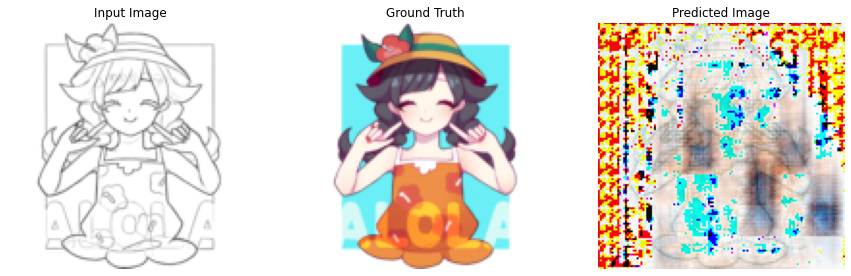

epoch number4
==10==20==30==40==50==60==70

KeyboardInterrupt: ignored

In [44]:
train(discriminator,generator,50,train_data_loader_A,test_data_loader_A) 

In [ ]:
generator.eval()

P2P_Generator(
  (c1): Conv2d(3, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (b1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (a1): LeakyReLU(negative_slope=True)
  (c2): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (b2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (a2): LeakyReLU(negative_slope=True)
  (c3): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (b3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (a3): LeakyReLU(negative_slope=True)
  (c4): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (b4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (a4): LeakyReLU(negative_slope=True)
  (ct4): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bt4): BatchNorm2d(32, eps=1e-05, momen

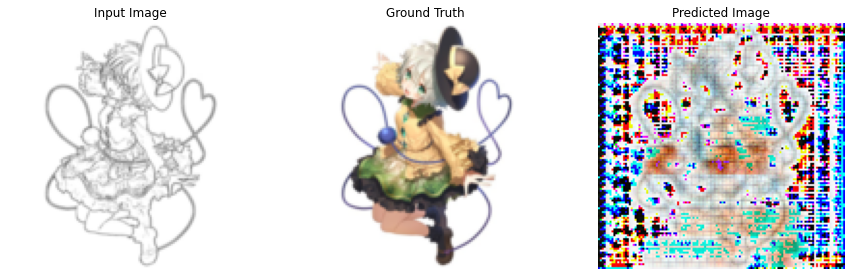

In [ ]:
ex_color, ex_sketch = next(iter(test_data_loader_A))
# ex_color = ex_color[0,:,:,:].unsqueeze(0)
# ex_sketch = ex_sketch[0,:,:,:].unsqueeze(0)
# print(ex_color.shape)
generate_images(generator, ex_color.to(device), ex_sketch.to(device))


ValueError: ignored

<Figure size 1080x1080 with 0 Axes>